# 🎓 Mafia Game — Pre-Game Winner Prediction

This notebook builds a **leak-free, pre-game prediction model** for Mafia games.
We go from **clean per-player rows** to **per-game team probabilities** using:
- Temporal **Elo with decay** (skills evolve over time)
- **Role & side** rolling performance
- **Breaks**/freshness
- **Role-specific history** (experience & win rates on each role)
- **Synergy** (same-team familiarity) & **Enemy familiarity** (cross-team history)
- **Streaks** (win/loss momentum)
- **Meta-eras** (ruleset changes over time)
- **Team aggregation** → opponent deltas
- **LightGBM** (main) and optional **CatBoost** (comparison), with **probability calibration**
- Proper **time-aware evaluation** (holdout = last 15% by time proxy)


## 1) Environment & Imports

If something is missing, install via the first cell. Then import everything we need.


In [1]:
# If needed, uncomment to install packages
# !pip install -q lightgbm catboost scikit-learn optuna matplotlib pandas numpy

import pandas as pd
import numpy as np
from pathlib import Path

# Modeling & metrics
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# Optional
try:
    from catboost import CatBoostClassifier, Pool
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

import matplotlib.pyplot as plt


## 2) Configuration & Data Load

- **Input:** a cleaned per-player table (one row per player per game).  
  Columns required (min): `id, game_id, player_id, role, team, place, game_points, team_win`  
- **Assumptions:** each game has **10 players**; exactly **one team wins** (7 winners if citizens, 3 if mafia).  
- **Time proxy:** `id` increases with time.

> Update `DATA_CSV` if your file is in a different location.


In [2]:
DATA_CSV = Path("cleaned/mafia_clean.csv")   # put the CSV next to this notebook or provide an absolute path
OUT_DIR  = Path("cleaned"); OUT_DIR.mkdir(exist_ok=True, parents=True)

df = pd.read_csv(DATA_CSV)
print("Loaded:", df.shape, "columns:", len(df.columns))
assert {'id','game_id','player_id','role','team','game_points','team_win'}.issubset(df.columns), \
    "Missing required columns in the cleaned dataset."

# Basic coercions
df['id'] = pd.to_numeric(df['id'], errors='coerce').astype('int64')
df['game_id'] = pd.to_numeric(df['game_id'], errors='coerce').astype('int64')
df['player_id'] = pd.to_numeric(df['player_id'], errors='coerce').astype('int64')
df['team_win'] = pd.to_numeric(df['team_win'], errors='coerce').astype('int8')
df['team'] = df['team'].astype('category')
df['role'] = df['role'].astype('category')

# Seat/position optional column name normalization (if present)
if 'place' in df.columns:
    df['place'] = pd.to_numeric(df['place'], errors='coerce').fillna(0).astype('int16')


Loaded: (802820, 21) columns: 21


C:\Users\user\AppData\Local\Temp\ipykernel_44808\712523340.py:4: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_CSV)


## 3) Helper Utilities

Small helpers for quantiles and sanity checks.


In [3]:
def q25(x): return np.nanpercentile(x, 25)
def q75(x): return np.nanpercentile(x, 75)

def sanity_assert_two_rows_per_game(team_tall):
    cnt = team_tall.groupby('game_id').size().value_counts()
    print("Rows per game distribution:\n", cnt.head())
    assert 2 in cnt.index.tolist(), "Every game should have exactly 2 rows (one per team)."

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if mask.sum() == 0: 
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return ece


## 4) Feature Engineering (Player-level)

We compute **pre-game** features only (no leakage):
- **Temporal Elo with decay** (global, by side, by role)
- **Side & role** rolling performance
- **Breaks/freshness** via id gaps
- **Role-specific history** (experience and WR on that role)
- **Same-team synergy** & **Enemy familiarity**
- **Streaks** (win/loss)
- **Meta eras** (bucket by id)


### 4.1 Meta eras & gap features
- `meta_period`: bucket `id` into eras to capture rule changes.
- `gap_id` per player → `gap_id_clipped` (bounded) and `long_break_flag`.


In [4]:
# Meta eras
bins   = [0, 200_000, 400_000, 600_000, 800_000, 1_000_000_000]
labels = [1, 2, 3, 4, 5]
df['meta_period'] = pd.cut(df['id'], bins=bins, labels=labels, include_lowest=True).astype('int8')

# Gap per player (id as time proxy)
df = df.sort_values(['player_id','id']).copy()
df['gap_id'] = df.groupby('player_id')['id'].diff().fillna(0).astype('int64')
df['gap_id_clipped'] = np.clip(df['gap_id'], 0, 5000).astype('int32')
GAP_THRESH = 381  # adjust via quantiles if desired
df['long_break_flag'] = (df['gap_id'] >= GAP_THRESH).astype('int8')

# Restore global order
df = df.sort_values('id').reset_index(drop=True)


### 4.2 Temporal Elo with decay
We update Elo **after** each game. Each update is scaled by `exp(-gap/tau)` so **older inactivity** reduces update size.


In [5]:
def compute_elos(dfin, init=1500, k=24, tau=300.0):
    d = dfin.sort_values('id').copy()
    elo_global, elo_side, elo_role = {}, {}, {}
    last_seen = {}
    outs = []

    for gid, g in d.groupby('game_id', sort=False):
        cur = g.copy()
        cur['pre_elo']      = [elo_global.get(pid, init) for pid in cur['player_id']]
        cur['pre_elo_side'] = [elo_side.get((pid, team), init) for pid, team in zip(cur['player_id'], cur['team'])]
        cur['pre_elo_role'] = [elo_role.get((pid, role), init) for pid, role in zip(cur['player_id'], cur['role'])]

        maf_mask  = cur['team'].eq('mafia')
        mafia_mu  = cur.loc[maf_mask, 'pre_elo'].mean()
        citizen_mu= cur.loc[~maf_mask, 'pre_elo'].mean()
        exp_mafia = 1.0 / (1.0 + 10 ** ((citizen_mu - mafia_mu)/400))
        mafia_res = int(cur.loc[maf_mask, 'team_win'].iloc[0])

        for _, r in cur.iterrows():
            pid, side, role, rid = int(r['player_id']), r['team'], r['role'], int(r['id'])
            gap = rid - last_seen.get(pid, rid)
            decay = float(np.exp(-max(gap,0)/float(tau)))
            exp = exp_mafia if side=='mafia' else (1-exp_mafia)
            act = mafia_res if side=='mafia' else (1-mafia_res)
            delta = k * decay * (act - exp)

            elo_global[pid] = elo_global.get(pid,  init) + delta
            elo_side[(pid, side)] = elo_side.get((pid, side), init) + delta
            elo_role[(pid, role)] = elo_role.get((pid, role), init) + delta
            last_seen[pid] = rid

        outs.append(cur[['game_id','player_id','pre_elo','pre_elo_side','pre_elo_role']])

    elo_df = pd.concat(outs, ignore_index=True)
    return d.merge(elo_df, on=['game_id','player_id'], how='left')

work_players = compute_elos(df, init=1500, k=24, tau=300.0)


### 4.3 Side-aware rolling win rates
We track recent **team win** rates for each player **on each side** separately (mafia/citizens).


In [6]:
def add_rolling_stats_side(df, windows=(5,20)):
    d = df.sort_values(['player_id','id']).copy()
    for side in ['mafia','citizens']:
        mask = d['team'].eq(side)
        d.loc[mask, f'roll5_win_rate_{side}']  = d.loc[mask].groupby('player_id')['team_win'].shift(1).rolling(windows[0], min_periods=1).mean().values
        d.loc[mask, f'roll20_win_rate_{side}'] = d.loc[mask].groupby('player_id')['team_win'].shift(1).rolling(windows[1], min_periods=1).mean().values
        d.loc[~mask, f'roll5_win_rate_{side}']  = 0.0
        d.loc[~mask, f'roll20_win_rate_{side}'] = 0.0
    return d

work_players = add_rolling_stats_side(work_players)


### 4.4 Role-specific history
For each `(player, role)` compute:
- `games_in_role` (prior count)
- `win_rate_role_<role>_last{W}` for W in {5, 20, 50}


In [7]:
def add_role_history_stats(df, windows=(5,20,50)):
    d = df.sort_values(['player_id','role','id']).copy()
    out = []
    for (pid, role), g in d.groupby(['player_id','role'], sort=False):
        g = g.copy()
        past = g['team_win'].shift(1)
        g['games_in_role'] = np.arange(len(g), dtype=np.int32)
        for w in windows:
            g[f'win_rate_role_{role}_last{w}'] = past.rolling(w, min_periods=1).mean()
        out.append(g)
    return pd.concat(out, ignore_index=True).sort_values('id').reset_index(drop=True)

work_players = add_role_history_stats(work_players, windows=(5,20,50))


C:\Users\user\AppData\Local\Temp\ipykernel_44808\1064261818.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (pid, role), g in d.groupby(['player_id','role'], sort=False):


### 4.5 Same-team synergy
Count prior **same-team co-plays** for all teammate pairs before this game, aggregate per team.


In [8]:
from itertools import combinations

def add_synergy_features(df):
    d = df.copy()
    game_order = (d.groupby('game_id')['id'].max().sort_values().index.tolist())
    pair_counts = {}
    out_rows = []

    for gid in game_order:
        g = d[d['game_id'] == gid]
        for team in ['mafia', 'citizens']:
            players = g.loc[g['team']==team, 'player_id'].dropna().astype(int).tolist()
            vals = [pair_counts.get((a,b,team), 0) for a,b in combinations(sorted(players), 2)] if len(players)>=2 else []
            s_mean = float(np.mean(vals)) if vals else 0.0
            s_max  = float(np.max(vals))  if vals else 0.0
            out_rows.append((gid, team, s_mean, s_max))
        # update after
        for team in ['mafia', 'citizens']:
            players = g.loc[g['team']==team, 'player_id'].dropna().astype(int).tolist()
            if len(players)>=2:
                for a,b in combinations(sorted(players), 2):
                    pair_counts[(a,b,team)] = pair_counts.get((a,b,team),0) + 1

    team_synergy = pd.DataFrame(out_rows, columns=['game_id','team','synergy_mean_team','synergy_max_team'])
    return d.merge(team_synergy, on=['game_id','team'], how='left')

work_players = add_synergy_features(work_players)


### 4.6 Enemy familiarity (cross-team history)
Count how often each player has faced each opponent **before** this game. Aggregate per team.


In [9]:
from itertools import product

def add_enemy_familiarity_features(df):
    d = df.sort_values('id').copy()
    game_order = (d.groupby('game_id')['id'].max().sort_values().index.tolist())
    faced_counts = {}
    out_rows = []

    for gid in game_order:
        g = d[d['game_id'] == gid]
        maf = g[g['team']=='mafia']['player_id'].dropna().astype(int).tolist()
        cit = g[g['team']=='citizens']['player_id'].dropna().astype(int).tolist()

        pairs_maf = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(maf, cit)]
        pairs_cit = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(cit, maf)]

        def stats(vals):
            return (float(np.mean(vals)) if vals else 0.0,
                    float(np.max(vals))  if vals else 0.0)

        maf_mean, maf_max = stats(pairs_maf)
        cit_mean, cit_max = stats(pairs_cit)

        out_rows.append((gid,'mafia',    maf_mean, maf_max))
        out_rows.append((gid,'citizens', cit_mean, cit_max))

        for a,b in product(maf, cit):
            key = tuple(sorted([int(a),int(b)]))
            faced_counts[key] = faced_counts.get(key, 0) + 1

    fam = pd.DataFrame(out_rows, columns=['game_id','team','enemy_fam_mean_team','enemy_fam_max_team'])
    return d.merge(fam, on=['game_id','team'], how='left')

work_players = add_enemy_familiarity_features(work_players)


### 4.7 Win/Loss streaks
Compute **pre-game** consecutive win and loss streak lengths for each player.


In [10]:
def add_streak_features(df):
    d = df.sort_values(['player_id','id']).copy()
    win_streaks, loss_streaks = [], []

    for pid, g in d.groupby('player_id', sort=False):
        prev = g['team_win'].shift(1).values
        w_stk = np.zeros(len(g), dtype=np.int16)
        l_stk = np.zeros(len(g), dtype=np.int16)
        cur_w = cur_l = 0
        for i, v in enumerate(prev):
            if np.isnan(v):
                cur_w = cur_l = 0
            else:
                if v == 1:
                    cur_w += 1; cur_l = 0
                else:
                    cur_l += 1; cur_w = 0
            w_stk[i] = cur_w
            l_stk[i] = cur_l
        win_streaks.append(pd.Series(w_stk, index=g.index))
        loss_streaks.append(pd.Series(l_stk, index=g.index))

    d['win_streak']  = pd.concat(win_streaks).sort_index()
    d['loss_streak'] = pd.concat(loss_streaks).sort_index()
    return d.sort_values('id').reset_index(drop=True)

work_players = add_streak_features(work_players)


### 4.8 Games played to date (per player)
Cumulative count of past games per player (pre-game). Useful as a general “experience” signal.


In [11]:
def add_games_played_feature(df):
    d = df.sort_values(['player_id','id']).copy()
    # number of *prior* appearances (shift to avoid leakage)
    d['games_played'] = d.groupby('player_id').cumcount().astype('int32')
    return d.sort_values('id').reset_index(drop=True)

work_players = add_games_played_feature(work_players)


## 5) Team-Level Aggregation & Deltas

Aggregate player features to `(game_id, team)` rows. Then create **safe deltas**: `mafia − citizens`.  
We **never** delta the target or `meta_period`.


In [12]:
def build_team_agg(work_players, add_ratios=False, ratio_eps=1e-3):
    agg_funcs = {}

    def add_agg(col, funcs):
        if col in work_players.columns:
            agg_funcs[col] = funcs

    # Core
    add_agg('pre_elo', ['mean','std','min','max', q25, q75])
    add_agg('pre_elo_side', ['mean'])
    add_agg('pre_elo_role', ['mean'])
    add_agg('gap_id_clipped', ['mean','max'])
    add_agg('long_break_flag', ['sum'])
    add_agg('place', ['mean','std','min','max'])
    add_agg('games_played', ['mean','std','min','max'])  # if present

    # Optional blocks
    add_agg('win_streak', ['mean','max'])
    add_agg('loss_streak', ['mean','max'])
    add_agg('synergy_mean_team', ['mean'])
    add_agg('synergy_max_team',  ['mean'])
    add_agg('enemy_fam_mean_team', ['mean'])
    add_agg('enemy_fam_max_team',  ['mean'])
    add_agg('roll5_win_rate_mafia',  ['mean'])
    add_agg('roll20_win_rate_mafia', ['mean'])
    add_agg('roll5_win_rate_citizens',  ['mean'])
    add_agg('roll20_win_rate_citizens', ['mean'])
    if 'meta_period' in work_players.columns:
        agg_funcs['meta_period'] = ['first']

    base = work_players.groupby(['game_id','team']).agg(agg_funcs)
    base.columns = ['_'.join([str(x) for x in c if x not in (None,)]).replace('<function ','').replace('>','')
                    for c in base.columns]
    base = base.reset_index()

    # --- NEW: meta-period normalization for Elo stats (remove era drift) ---
    if 'meta_period_first' in base.columns:
        elo_cols = [c for c in base.columns if c.startswith('pre_elo_')]
        for col in elo_cols:
            # center within meta-period
            base[f'{col}_norm'] = base[col] - base.groupby('meta_period_first')[col].transform('mean')

    # Role-specific singletons/means
    full_idx = base.set_index(['game_id','team']).index
    # Role-specific singletons/means
    full_idx = base.set_index(['game_id','team']).index

    def single_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role']==role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name; return s

    def mean_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role']==role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name; return s

    pieces = [
        single_role_stat('don','pre_elo_role','don_pre_elo_role'),
        single_role_stat('sheriff','pre_elo_role','sheriff_pre_elo_role'),
        single_role_stat('don','place','don_place'),
        single_role_stat('sheriff','place','sheriff_place'),
        mean_role_stat('black','pre_elo_role','black_mean_pre_elo_role'),
        mean_role_stat('red','pre_elo_role','red_mean_pre_elo_role'),
        single_role_stat('don','games_in_role','don_games_in_role'),
        single_role_stat('sheriff','games_in_role','sheriff_games_in_role'),
        mean_role_stat('black','games_in_role','black_mean_games_in_role'),
        mean_role_stat('red','games_in_role','red_mean_games_in_role'),
        single_role_stat('don','win_rate_role_don_last20','don_wr20'),
        single_role_stat('sheriff','win_rate_role_sheriff_last20','sheriff_wr20'),
        mean_role_stat('black','win_rate_role_black_last20','black_mean_wr20'),
        mean_role_stat('red','win_rate_role_red_last20','red_mean_wr20'),
    ]
    role_feats = pd.concat(pieces, axis=1).reset_index()
    team_agg = base.merge(role_feats, on=['game_id','team'], how='left')

    # Label & time proxy
    labels  = work_players.groupby(['game_id','team'])['team_win'].max().rename('team_win_team')
    gmaxid  = work_players.groupby('game_id')['id'].max().rename('game_max_id')
    team_agg = team_agg.merge(labels, on=['game_id','team']).merge(gmaxid, on='game_id')

    # Safe deltas / ratios
    wide = team_agg.pivot(index='game_id', columns='team')
    wide.columns = [f"{a}__{b}" for a,b in wide.columns]
    wide = wide.reset_index()

    def side_cols(side): 
        return [c for c in wide.columns if c.endswith(f"__{side}") and c!='game_id']
    maf_cols = side_cols('mafia')

    delta = pd.DataFrame({'game_id': wide['game_id']})
    skip_prefixes = ('team_win_team','meta_period')
    for mcol in maf_cols:
        base_name = mcol[:-len("__mafia")]
        if base_name.startswith(skip_prefixes): 
            continue
        ccol = base_name + "__citizens"
        if ccol in wide.columns:
            delta[base_name + "__delta_maf_minus_cit"] = wide[mcol] - wide[ccol]
            if add_ratios:
                delta[base_name + "__ratio_maf_over_cit"] = (wide[mcol] + ratio_eps) / (wide[ccol] + ratio_eps)

    team_tall = team_agg.merge(delta, on='game_id', how='left')

    # --- NEW: a few safe interactions (helps tree models separate regimes) ---
    def safe_mul(a, b): 
        return (team_tall.get(a) if a in team_tall else 0) * (team_tall.get(b) if b in team_tall else 0)

    def safe_diff(a, b): 
        return (team_tall.get(a) if a in team_tall else 0) - (team_tall.get(b) if b in team_tall else 0)

    # Names used below exist after delta creation; if any is missing in your run, it's treated as 0
    team_tall['elo_synergy_product'] = safe_mul('pre_elo_mean__delta_maf_minus_cit',
                                                'synergy_mean_team_mean__delta_maf_minus_cit')
    team_tall['elo_enemy_gap']       = safe_diff('pre_elo_mean__delta_maf_minus_cit',
                                                'enemy_fam_mean_team_mean__delta_maf_minus_cit')
    team_tall['elo_streak_mix']      = safe_mul('pre_elo_mean__delta_maf_minus_cit',
                                                'win_streak_mean__delta_maf_minus_cit')

    return team_tall

team_tall = build_team_agg(work_players, add_ratios=False)  # ratios often redundant
sanity_assert_two_rows_per_game(team_tall)


Rows per game distribution:
 2    80282
Name: count, dtype: int64


## 6) Feature Selection

We include **team-only** features and **deltas**. We **exclude** label-like columns.
Then we create **time-aware** train/cal/test splits (70/15/15 by `game_max_id`).


In [13]:
team_only = [c for c in team_tall.columns if c.startswith((
    'pre_elo_', 'gap_id_clipped_', 'long_break_flag_', 'place_',
    'win_streak_', 'loss_streak_', 'synergy_mean_team_', 'synergy_max_team_',
    'enemy_fam_', 'games_played_', 
    'don_pre_elo_role', 'sheriff_pre_elo_role', 'black_mean_pre_elo_role', 'red_mean_pre_elo_role',
    'don_games_in_role', 'sheriff_games_in_role', 'black_mean_games_in_role', 'red_mean_games_in_role',
    'don_wr20', 'sheriff_wr20', 'black_mean_wr20', 'red_mean_wr20',
    'meta_period_first'
))]
delta_feats = [c for c in team_tall.columns if c.endswith('__delta_maf_minus_cit')]

# NEW: explicitly add our interactions and meta-normalized Elo columns
extra_feats = [c for c in ['elo_synergy_product','elo_enemy_gap','elo_streak_mix']
               if c in team_tall.columns]
meta_norm_feats = [c for c in team_tall.columns if c.endswith('_norm')]

forbidden_tokens = {'team_win','team_win_team'}
USED_FEATS = [c for c in sorted(set(team_only + delta_feats + extra_feats + meta_norm_feats))
              if not any(tok in c for tok in forbidden_tokens)]

X = team_tall[USED_FEATS].fillna(0)
y = team_tall['team_win_team'].astype(int).values
groups = team_tall['game_id'].values
time_key = team_tall['game_max_id'].values

q70, q85 = np.quantile(time_key, [0.70, 0.85])
train_mask = time_key <= q85
cal_mask   = (time_key > q70) & (time_key <= q85)
test_mask  = time_key > q85

print("Shapes | X:", X.shape, "| y:", y.shape)
print("Split sizes | train:", train_mask.sum(), "cal:", cal_mask.sum(), "test:", test_mask.sum())


Shapes | X: (160564, 105) | y: (160564,)
Split sizes | train: 136480 cal: 24084 test: 24084


## 7) Model — LightGBM (calibrated)
Train on train, calibrate on cal (sigmoid), evaluate on holdout (last 15%).


In [14]:
params = dict(
    n_estimators=1500,
    learning_rate=0.01,
    num_leaves=127,
    min_data_in_leaf=60,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Optional inner early stopping on last 10% of train
tr_time = time_key[train_mask]; q90 = np.quantile(tr_time, 0.90)
inner_tr = train_mask & (time_key <= q90)
inner_va = train_mask & (time_key >  q90)

lgb = LGBMClassifier(**params)
lgb.fit(
    X[inner_tr], y[inner_tr],
    eval_set=[(X[inner_va], y[inner_va])],
    eval_metric='logloss',
    callbacks=[early_stopping(100), log_evaluation(0)]
)

# Freeze the already-fitted estimator (workaround for prefit deprecation)
frozen = clone(lgb)
frozen.__dict__.update(lgb.__dict__)

# Sigmoid (Platt) calibration on the calibration slice
calibrated = CalibratedClassifierCV(frozen, cv="prefit", method="sigmoid")
calibrated.fit(X[cal_mask], y[cal_mask])

p_test = calibrated.predict_proba(X[test_mask])[:,1]

print("Holdout (last 15%)")
print("LogLoss:", log_loss(y[test_mask], p_test))
print("ROC-AUC:", roc_auc_score(y[test_mask], p_test))
print("Brier  :", brier_score_loss(y[test_mask], p_test))


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.669491
[LightGBM] [Warning] min_data_in_leaf is set=60, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Holdout (last 15%)
LogLoss: 0.6682037215973543
ROC-AUC: 0.6314228364649983
Brier  : 0.23769559892684958


## 8) Calibration Diagnostics

Reliability curve and **ECE** (Expected Calibration Error) on holdout.


ECE (10 bins): 0.0243


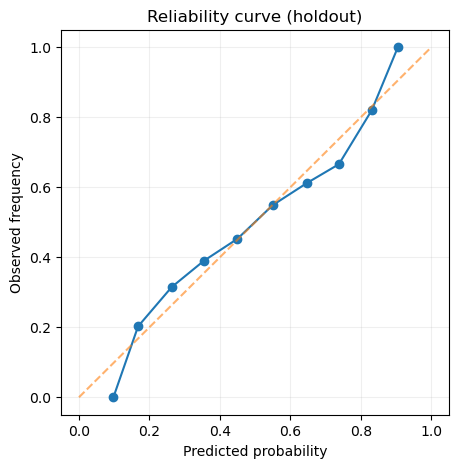

In [15]:
ece = expected_calibration_error(y[test_mask], p_test, n_bins=10)
print(f"ECE (10 bins): {ece:.4f}")

prob_true, prob_pred = calibration_curve(y[test_mask], p_test, n_bins=10)
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability curve (holdout)')
plt.grid(alpha=0.2); plt.show()


## 9) (Optional) CatBoost + Calibration + Blend

CatBoost often complements tree ensembles. We calibrate its probabilities and optionally blend.


In [16]:
if CATBOOST_AVAILABLE:
    X_train, y_train = X[train_mask], y[train_mask]
    X_cal,   y_cal   = X[cal_mask],   y[cal_mask]
    X_hold,  y_hold  = X[test_mask],  y[test_mask]

    cat_features = []
    if 'meta_period_first' in X.columns:
        cat_features.append(X.columns.get_loc('meta_period_first'))

    train_pool = Pool(X_train, y_train, cat_features=cat_features or None)
    cal_pool   = Pool(X_cal,   y_cal,   cat_features=cat_features or None)
    test_pool  = Pool(X_hold,  y_hold,  cat_features=cat_features or None)

    cat = CatBoostClassifier(
        iterations=2500,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3.0,
        random_seed=42,
        eval_metric='Logloss',
        loss_function='Logloss',
        class_weights=[1.0, 2.3],
        use_best_model=True,
        verbose=200
    )
    cat.fit(train_pool, eval_set=cal_pool)

   # Sigmoid (baseline)
    cat_cal_sig = CalibratedClassifierCV(cat, cv='prefit', method='sigmoid').fit(X[cal_mask], y[cal_mask])
    p_cat_sig = cat_cal_sig.predict_proba(X[test_mask])[:,1]

    # Isotonic (may help CatBoost LogLoss if enough cal data)
    cat_cal_iso = CalibratedClassifierCV(cat, cv='prefit', method='isotonic').fit(X[cal_mask], y[cal_mask])
    p_cat_iso = cat_cal_iso.predict_proba(X[test_mask])[:,1]

    # Pick the better calibrated CatBoost for blending (by LogLoss)
    ll_sig = log_loss(y[test_mask], p_cat_sig)
    ll_iso = log_loss(y[test_mask], p_cat_iso)
    if ll_iso < ll_sig:
        p_cat = p_cat_iso
        print("Using CatBoost isotonic calibration (better LogLoss).")
    else:
        p_cat = p_cat_sig
        print("Using CatBoost sigmoid calibration (better or equal LogLoss).")

    print("\nCatBoost (calibrated) — Holdout")
    print("LogLoss:", log_loss(y[test_mask], p_cat))
    print("ROC-AUC:", roc_auc_score(y[test_mask], p_cat))
    print("Brier  :", brier_score_loss(y[test_mask], p_cat))

    # blend
    w_lgbm = 0.6
    w_cat  = 0.4
    p_blend = w_lgbm * p_test + w_cat * p_cat
    print(f"\nBlend {w_lgbm:.1f}·LGBM + {w_cat:.1f}·Cat — Holdout")

    print("LogLoss:", log_loss(y[test_mask], p_blend))
    print("ROC-AUC:", roc_auc_score(y[test_mask], p_blend))
    print("Brier  :", brier_score_loss(y[test_mask], p_blend))
else:
    print("CatBoost not installed — skipping optional block.")


0:	learn: 0.6893339	test: 0.6893531	best: 0.6893531 (0)	total: 183ms	remaining: 7m 36s
200:	learn: 0.5910732	test: 0.5931854	best: 0.5931854 (200)	total: 5.03s	remaining: 57.5s
400:	learn: 0.5841623	test: 0.5871387	best: 0.5871387 (400)	total: 9.69s	remaining: 50.7s
600:	learn: 0.5789110	test: 0.5824664	best: 0.5824664 (600)	total: 14.3s	remaining: 45.1s
800:	learn: 0.5727988	test: 0.5770407	best: 0.5770407 (800)	total: 18.8s	remaining: 39.9s
1000:	learn: 0.5670838	test: 0.5717026	best: 0.5717026 (1000)	total: 23.4s	remaining: 35s
1200:	learn: 0.5619706	test: 0.5669323	best: 0.5669323 (1200)	total: 27.9s	remaining: 30.2s
1400:	learn: 0.5570309	test: 0.5621194	best: 0.5621194 (1400)	total: 32.4s	remaining: 25.4s
1600:	learn: 0.5522208	test: 0.5575466	best: 0.5575466 (1600)	total: 37s	remaining: 20.8s
1800:	learn: 0.5479237	test: 0.5533899	best: 0.5533899 (1800)	total: 41.5s	remaining: 16.1s
2000:	learn: 0.5435121	test: 0.5491444	best: 0.5491444 (2000)	total: 46s	remaining: 11.5s
2200:	l

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### (Optional) XGBoost third learner
A slightly different tree engine sometimes helps the ensemble by a small margin.


In [17]:
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=1200, learning_rate=0.015,
        max_depth=7, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.5,
        objective='binary:logistic', eval_metric='logloss',
        random_state=42, n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    p_xgb = xgb.predict_proba(X_hold)[:,1]

    # quick 3-way blend (adjust weights after checking LogLoss)
    p_blend3 = 0.5*p_lgbm_final + 0.3*(p_cat if p_cat is not None else 0) + 0.2*p_xgb
    print("\n3-way Blend — Holdout")
    print("LogLoss:", log_loss(y_hold, p_blend3))
    print("ROC-AUC:", roc_auc_score(y_hold, p_blend3))
    print("Brier  :", brier_score_loss(y_hold, p_blend3))
except Exception as e:
    print("XGBoost not available or failed to fit:", e)


XGBoost not available or failed to fit: name 'p_lgbm_final' is not defined


## 10) Summary & Next Steps

- Leak-free **pre-game** predictor, calibrated probabilities.
- Strong signals: Elo deltas/means, synergy, streaks, role history, freshness.
- Try: different **Elo decay** `tau`, **role-pair synergy**, **CatBoost blending**, or small **Optuna** tuning.


## 11) Quick Hyper-parameter & Blend Tuning (Optuna)

We tune a handful of high-impact LightGBM parameters and the blend weights
between LGBM and CatBoost. We keep a fixed learning rate and estimators for stability.


In [18]:
import optuna
from sklearn.base import clone

X_train, y_train = X[train_mask], y[train_mask]
X_cal,   y_cal   = X[cal_mask],   y[cal_mask]
X_hold,  y_hold  = X[test_mask],  y[test_mask]

def train_lgbm_with_params(params_dict):
    lgb = LGBMClassifier(
        n_estimators=1500,
        learning_rate=0.01,
        num_leaves=int(params_dict['num_leaves']),
        min_data_in_leaf=int(params_dict['min_data_in_leaf']),
        subsample=float(params_dict['subsample']),
        colsample_bytree=float(params_dict['colsample_bytree']),
        reg_lambda=float(params_dict['reg_lambda']),
        reg_alpha=float(params_dict['reg_alpha']),
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    # inner early-stop on last 10% of train time
    tr_t = time_key[train_mask]; q90 = np.quantile(tr_t, 0.90)
    inner_tr = (time_key <= q90) & train_mask
    inner_va = (time_key >  q90) & train_mask

    lgb.fit(
        X[inner_tr], y[inner_tr],
        eval_set=[(X[inner_va], y[inner_va])],
        eval_metric='logloss',
        callbacks=[early_stopping(100), log_evaluation(0)]
    )
    # Calibrate on cal split (sigmoid)
    fr = clone(lgb); fr.__dict__.update(lgb.__dict__)
    cal = CalibratedClassifierCV(fr, cv='prefit', method='sigmoid')
    cal.fit(X_cal, y_cal)
    p = cal.predict_proba(X_hold)[:,1]
    return p, lgb

# Cache CatBoost predictions from your earlier section (if available)
# If not run yet, train a small Cat here:
if CATBOOST_AVAILABLE:
    try:
        p_cat  # exists
    except NameError:
        train_pool = Pool(X_train, y_train)
        cal_pool   = Pool(X_cal,   y_cal)
        cat = CatBoostClassifier(
            iterations=2000, learning_rate=0.02, depth=8,
            l2_leaf_reg=3.0, random_seed=42,
            eval_metric='Logloss', loss_function='Logloss',
            auto_class_weights='Balanced',
            use_best_model=True, verbose=False
        )
        cat.fit(train_pool, eval_set=cal_pool, verbose=False)
        cat_cal = CalibratedClassifierCV(cat, cv='prefit', method='sigmoid').fit(X_cal, y_cal)
        p_cat = cat_cal.predict_proba(X_hold)[:,1]
else:
    p_cat = None  # tuning will ignore blend weight

def objective(trial: optuna.Trial):
    # LGBM params to tune (narrow, safe ranges)
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 63, 159),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 140),
        'subsample': trial.suggest_float('subsample', 0.70, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 1.00),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 3.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 3.0),
    }
    p_lgbm, _ = train_lgbm_with_params(params)

    if p_cat is not None:
        w_lgbm = trial.suggest_float('w_lgbm', 0.4, 0.9)
        w_cat  = 1.0 - w_lgbm
        p_blend = w_lgbm * p_lgbm + w_cat * p_cat
        loss = log_loss(y_hold, p_blend)
    else:
        loss = log_loss(y_hold, p_lgbm)

    # report auxiliary metrics
    trial.set_user_attr('AUC', roc_auc_score(y_hold, p_lgbm if p_cat is None else p_blend))
    trial.set_user_attr('Brier', brier_score_loss(y_hold, p_lgbm if p_cat is None else p_blend))
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=False)

print("Best LogLoss:", study.best_value)
print("Best params:", study.best_params)
print("Best AUC (attr):", study.best_trial.user_attrs.get('AUC'))
print("Best Brier (attr):", study.best_trial.user_attrs.get('Brier'))

# Refit final LGBM with best params and produce final blended predictions
best_params = study.best_params.copy()
w_lgbm = best_params.pop('w_lgbm', 1.0)  # present only if CatBoost available
p_lgbm_final, lgb_final = train_lgbm_with_params(best_params)

if p_cat is not None:
    w_cat = 1.0 - w_lgbm
    p_final = w_lgbm * p_lgbm_final + w_cat * p_cat
    print(f"\nFinal blend weights: LGBM={w_lgbm:.2f}, Cat={w_cat:.2f}")
else:
    p_final = p_lgbm_final

print("\nTuned — Holdout")
print("LogLoss:", log_loss(y_hold, p_final))
print("ROC-AUC:", roc_auc_score(y_hold, p_final))
print("Brier  :", brier_score_loss(y_hold, p_final))


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-11 16:59:47,661] A new study created in memory with name: no-name-c0927e53-5086-4745-9fd6-7e98f3ae250f


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.669265
[LightGBM] [Warning] min_data_in_leaf is set=55, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 16:59:53,424] Trial 0 finished with value: 0.6702879063167039 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 55, 'subsample': 0.8778177999440697, 'colsample_bytree': 0.9456702039773609, 'reg_lambda': 2.6320068234214364, 'reg_alpha': 0.28655211868513675, 'w_lgbm': 0.7954719223803706}. Best is trial 0 with value: 0.6702879063167039.


[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.669673
[LightGBM] [Warning] min_data_in_leaf is set=104,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 16:59:58,783] Trial 1 finished with value: 0.6775063280477456 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 104, 'subsample': 0.7030666875590743, 'colsample_bytree': 0.9728503450743742, 'reg_lambda': 2.853594435575606, 'reg_alpha': 0.3935870309038906, 'w_lgbm': 0.4630427923215505}. Best is trial 0 with value: 0.6702879063167039.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.669956
[LightGBM] [Warning] min_data_in_leaf is set=61, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:03,868] Trial 2 finished with value: 0.6720315857305547 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 61, 'subsample': 0.7116117849869308, 'colsample_bytree': 0.8223938458514819, 'reg_lambda': 2.6718834090303365, 'reg_alpha': 2.541119044174989, 'w_lgbm': 0.6571693831668309}. Best is trial 0 with value: 0.6702879063167039.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.669933
[LightGBM] [Warning] min_data_in_leaf is set=96, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:08,428] Trial 3 finished with value: 0.6722063384592516 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 96, 'subsample': 0.8580504300876995, 'colsample_bytree': 0.9472205508341092, 'reg_lambda': 2.9459941454726537, 'reg_alpha': 1.7492164394997305, 'w_lgbm': 0.5940884697434194}. Best is trial 0 with value: 0.6702879063167039.


[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:12,784] Trial 4 finished with value: 0.6733304837176559 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 115, 'subsample': 0.897144550811581, 'colsample_bytree': 0.9861260820295046, 'reg_lambda': 1.6887299720679558, 'reg_alpha': 2.1717444169837687, 'w_lgbm': 0.5403939910211577}. Best is trial 0 with value: 0.6702879063167039.


Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.669654
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:17,410] Trial 5 finished with value: 0.6757075500320859 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 65, 'subsample': 0.7628256514821612, 'colsample_bytree': 0.767625908483716, 'reg_lambda': 2.674658000319066, 'reg_alpha': 0.009809361678845385, 'w_lgbm': 0.517040078791344}. Best is trial 0 with value: 0.6702879063167039.


[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:22,158] Trial 6 finished with value: 0.6699984919771609 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 119, 'subsample': 0.9190320113420472, 'colsample_bytree': 0.9301432767918967, 'reg_lambda': 2.2405225092110257, 'reg_alpha': 1.6390300507453017, 'w_lgbm': 0.7123495615953888}. Best is trial 6 with value: 0.6699984919771609.


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.669648
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:26,398] Trial 7 finished with value: 0.676910625460669 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 129, 'subsample': 0.7247912343764197, 'colsample_bytree': 0.8757639916505358, 'reg_lambda': 0.8808620281911324, 'reg_alpha': 2.6478744674912296, 'w_lgbm': 0.4487709475967487}. Best is trial 6 with value: 0.6699984919771609.


Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.669972
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:30,455] Trial 8 finished with value: 0.6672874043243403 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 127, 'subsample': 0.7812162436251557, 'colsample_bytree': 0.7968558242057955, 'reg_lambda': 0.40619360902901613, 'reg_alpha': 0.19464019252917275, 'w_lgbm': 0.8732430209357275}. Best is trial 8 with value: 0.6672874043243403.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:34,395] Trial 9 finished with value: 0.673315179529166 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 52, 'subsample': 0.7246610333400506, 'colsample_bytree': 0.8972882174524941, 'reg_lambda': 1.496379037937385, 'reg_alpha': 0.4758808651411035, 'w_lgbm': 0.5239512925266221}. Best is trial 8 with value: 0.6672874043243403.


Early stopping, best iteration is:
[426]	valid_0's binary_logloss: 0.670255
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:39,222] Trial 10 finished with value: 0.6671894150287239 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 139, 'subsample': 0.8153181206510485, 'colsample_bytree': 0.7552114442679237, 'reg_lambda': 0.0927388280770357, 'reg_alpha': 0.9924905803343984, 'w_lgbm': 0.89540321119558}. Best is trial 10 with value: 0.6671894150287239.


[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's binary_logloss: 0.670331
[LightGBM] [Warning] min_data_in_leaf is set=133,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:44,355] Trial 11 finished with value: 0.6680843634263043 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 133, 'subsample': 0.8030336381515302, 'colsample_bytree': 0.7524281584046542, 'reg_lambda': 0.037746113829414285, 'reg_alpha': 0.9890443188884059, 'w_lgbm': 0.8921926531381046}. Best is trial 10 with value: 0.6671894150287239.


[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:47,824] Trial 12 finished with value: 0.6667443404917526 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 140, 'subsample': 0.8005350593397594, 'colsample_bytree': 0.8053461463248702, 'reg_lambda': 0.0633662331183157, 'reg_alpha': 0.9325578423454974, 'w_lgbm': 0.8747022822693388}. Best is trial 12 with value: 0.6667443404917526.


Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.670175
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:52,061] Trial 13 finished with value: 0.6682701642561294 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 139, 'subsample': 0.8333893851890392, 'colsample_bytree': 0.826884611591746, 'reg_lambda': 0.734460782412593, 'reg_alpha': 0.9727127372447347, 'w_lgbm': 0.8027031592131345}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's binary_logloss: 0.669551
[LightGBM] [Warning] min_data_in_leaf is set=80, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:00:57,367] Trial 14 finished with value: 0.6702395264233708 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 80, 'subsample': 0.8256695450528747, 'colsample_bytree': 0.7968417524830147, 'reg_lambda': 0.013879291117899317, 'reg_alpha': 1.0574828482274992, 'w_lgbm': 0.7873647617857317}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	valid_0's binary_logloss: 0.669817
[LightGBM] [Warning] min_data_in_leaf is set=110,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:02,267] Trial 15 finished with value: 0.6687985600637552 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 110, 'subsample': 0.7615563740007679, 'colsample_bytree': 0.8400526608200324, 'reg_lambda': 1.0519720766407956, 'reg_alpha': 1.3389125312413666, 'w_lgbm': 0.8464843275646171}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.669973
[LightGBM] [Warning] min_data_in_leaf is set=80, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:06,916] Trial 16 finished with value: 0.6692045151873273 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 80, 'subsample': 0.798567663561206, 'colsample_bytree': 0.7823489231649665, 'reg_lambda': 0.44639047492421685, 'reg_alpha': 0.7240933245052614, 'w_lgbm': 0.7338974153012283}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.670092
[LightGBM] [Warning] min_data_in_leaf is set=138,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:11,946] Trial 17 finished with value: 0.6701089297906622 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 138, 'subsample': 0.8515002484031007, 'colsample_bytree': 0.8529396583116949, 'reg_lambda': 1.3789573698191933, 'reg_alpha': 1.3475409771722755, 'w_lgbm': 0.7200296710176732}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:15,810] Trial 18 finished with value: 0.6678948560637294 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 126, 'subsample': 0.9440833995419893, 'colsample_bytree': 0.7508859413785877, 'reg_lambda': 0.3879453277959132, 'reg_alpha': 1.9589652451719801, 'w_lgbm': 0.8265165792150022}. Best is trial 12 with value: 0.6667443404917526.


Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.669776
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:20,965] Trial 19 finished with value: 0.671819431139676 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 99, 'subsample': 0.7498409712554994, 'colsample_bytree': 0.8081837668170814, 'reg_lambda': 1.9828223555538138, 'reg_alpha': 0.8280866642272678, 'w_lgbm': 0.6526895752988264}. Best is trial 12 with value: 0.6667443404917526.


Early stopping, best iteration is:
[313]	valid_0's binary_logloss: 0.66942
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:26,140] Trial 20 finished with value: 0.6679482313743139 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 81, 'subsample': 0.8048515041331871, 'colsample_bytree': 0.8607392468233231, 'reg_lambda': 1.105718174170926, 'reg_alpha': 0.6197723889204998, 'w_lgbm': 0.8915604863298618}. Best is trial 12 with value: 0.6667443404917526.


[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:29,797] Trial 21 finished with value: 0.6667325415212769 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 123, 'subsample': 0.7832897360708728, 'colsample_bytree': 0.7866295771711799, 'reg_lambda': 0.4120619599023918, 'reg_alpha': 1.2894899365250985, 'w_lgbm': 0.8626695342206523}. Best is trial 21 with value: 0.6667325415212769.


Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.670124
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:34,371] Trial 22 finished with value: 0.6690444170613604 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 121, 'subsample': 0.7847990417571508, 'colsample_bytree': 0.7755361641319708, 'reg_lambda': 0.2213310218511606, 'reg_alpha': 1.2413525825265057, 'w_lgbm': 0.765082139333608}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:37,860] Trial 23 finished with value: 0.6670178659158067 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 139, 'subsample': 0.8390930844961086, 'colsample_bytree': 0.7848408179811442, 'reg_lambda': 0.6292753946719332, 'reg_alpha': 1.4273826256942777, 'w_lgbm': 0.8361253181927962}. Best is trial 21 with value: 0.6667325415212769.


Early stopping, best iteration is:
[338]	valid_0's binary_logloss: 0.670204
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:43,341] Trial 24 finished with value: 0.6698696885884813 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 109, 'subsample': 0.8436231588364572, 'colsample_bytree': 0.815143991940156, 'reg_lambda': 0.6600988653546012, 'reg_alpha': 1.600217452435888, 'w_lgbm': 0.8404903806150157}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[467]	valid_0's binary_logloss: 0.67022
[LightGBM] [Warning] min_data_in_leaf is set=134, 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:47,607] Trial 25 finished with value: 0.6674949666001272 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 134, 'subsample': 0.8715766768122983, 'colsample_bytree': 0.7927325199822868, 'reg_lambda': 0.5877274941654931, 'reg_alpha': 1.9469963457484694, 'w_lgbm': 0.8518376331949101}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 0.669725
[LightGBM] [Warning] min_data_in_leaf is set=121,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:52,083] Trial 26 finished with value: 0.6691847851941661 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 121, 'subsample': 0.7510315980282433, 'colsample_bytree': 0.8354556525214912, 'reg_lambda': 1.1920664771633838, 'reg_alpha': 1.2517691583369779, 'w_lgbm': 0.7601599749931053}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[505]	valid_0's binary_logloss: 0.670169
[LightGBM] [Warning] min_data_in_leaf is set=130,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:01:56,777] Trial 27 finished with value: 0.6704270350649155 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 130, 'subsample': 0.7823498891346816, 'colsample_bytree': 0.7753381987627982, 'reg_lambda': 0.3018204288287789, 'reg_alpha': 2.2207285804820005, 'w_lgbm': 0.6954072080368632}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[693]	valid_0's binary_logloss: 0.669996
[LightGBM] [Warning] min_data_in_leaf is set=140,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:02,360] Trial 28 finished with value: 0.669098758621667 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 140, 'subsample': 0.8304534936480754, 'colsample_bytree': 0.8881126935827837, 'reg_lambda': 0.8166395929951853, 'reg_alpha': 1.4682902355678702, 'w_lgbm': 0.8229995538521531}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's binary_logloss: 0.669625
[LightGBM] [Warning] min_data_in_leaf is set=44, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:08,336] Trial 29 finished with value: 0.6720882228019102 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 44, 'subsample': 0.8908618594221072, 'colsample_bytree': 0.8034634640426128, 'reg_lambda': 0.5588953355752986, 'reg_alpha': 2.981062336175558, 'w_lgbm': 0.7710874342799785}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's binary_logloss: 0.669667
[LightGBM] [Warning] min_data_in_leaf is set=124,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:12,873] Trial 30 finished with value: 0.6683206132972078 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 124, 'subsample': 0.8708334264641001, 'colsample_bytree': 0.9105577405192472, 'reg_lambda': 0.18322343261866425, 'reg_alpha': 1.1255267424041584, 'w_lgbm': 0.8081158510267495}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[658]	valid_0's binary_logloss: 0.670173
[LightGBM] [Warning] min_data_in_leaf is set=140,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:17,726] Trial 31 finished with value: 0.6684880744013825 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 140, 'subsample': 0.8163837771881225, 'colsample_bytree': 0.7644473279923154, 'reg_lambda': 0.010830849053999135, 'reg_alpha': 0.801344112920995, 'w_lgbm': 0.8673527798859095}. Best is trial 21 with value: 0.6667325415212769.


[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:21,015] Trial 32 finished with value: 0.6665033737978745 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 134, 'subsample': 0.8140936140036887, 'colsample_bytree': 0.7844939514101106, 'reg_lambda': 0.1904075276204348, 'reg_alpha': 0.5453556057858624, 'w_lgbm': 0.8853110819376774}. Best is trial 32 with value: 0.6665033737978745.


Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.670257
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:25,287] Trial 33 finished with value: 0.6678242705985008 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 114, 'subsample': 0.7905354703348896, 'colsample_bytree': 0.7852081481535501, 'reg_lambda': 0.2944933235637514, 'reg_alpha': 0.5499868483163135, 'w_lgbm': 0.8595111091980658}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:28,793] Trial 34 finished with value: 0.6672041229194652 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 134, 'subsample': 0.7728571820718865, 'colsample_bytree': 0.8167620665861407, 'reg_lambda': 0.5180424788461451, 'reg_alpha': 1.4777928397462903, 'w_lgbm': 0.8224637500305981}. Best is trial 32 with value: 0.6665033737978745.


Early stopping, best iteration is:
[314]	valid_0's binary_logloss: 0.670063
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:33,184] Trial 35 finished with value: 0.6731332094845568 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 132, 'subsample': 0.8385884262785128, 'colsample_bytree': 0.8410418687453006, 'reg_lambda': 0.9028621765544254, 'reg_alpha': 0.16757667077979765, 'w_lgbm': 0.5782011069843686}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	valid_0's binary_logloss: 0.670151
[LightGBM] [Warning] min_data_in_leaf is set=106,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:37,151] Trial 36 finished with value: 0.670188526775576 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 106, 'subsample': 0.8142975245294765, 'colsample_bytree': 0.7693810327768256, 'reg_lambda': 0.19110368041293696, 'reg_alpha': 0.826880032401812, 'w_lgbm': 0.6770893101872744}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[505]	valid_0's binary_logloss: 0.669946
[LightGBM] [Warning] min_data_in_leaf is set=98, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:42,004] Trial 37 finished with value: 0.6684624404559285 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 98, 'subsample': 0.8595517663925211, 'colsample_bytree': 0.7902278770440415, 'reg_lambda': 0.6712569799113695, 'reg_alpha': 0.3777960008889183, 'w_lgbm': 0.8987868872226265}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.669781
[LightGBM] [Warning] min_data_in_leaf is set=115,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:46,712] Trial 38 finished with value: 0.6778483635600214 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 115, 'subsample': 0.888963226120655, 'colsample_bytree': 0.962881253101558, 'reg_lambda': 1.794843623380808, 'reg_alpha': 1.800425677937741, 'w_lgbm': 0.42486055305320103}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's binary_logloss: 0.670004
[LightGBM] [Warning] min_data_in_leaf is set=88, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:51,068] Trial 39 finished with value: 0.6690992692899548 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 88, 'subsample': 0.7707719010576933, 'colsample_bytree': 0.825843046165885, 'reg_lambda': 0.31439962866337956, 'reg_alpha': 0.6393046083847409, 'w_lgbm': 0.7483695855122356}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	valid_0's binary_logloss: 0.669712
[LightGBM] [Warning] min_data_in_leaf is set=125,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:02:55,976] Trial 40 finished with value: 0.6696534404759893 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 125, 'subsample': 0.7487588468043328, 'colsample_bytree': 0.8090925060559995, 'reg_lambda': 2.360426055577106, 'reg_alpha': 0.02472038401192811, 'w_lgbm': 0.7921495840784353}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	valid_0's binary_logloss: 0.67009
[LightGBM] [Warning] min_data_in_leaf is set=134, 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:01,429] Trial 41 finished with value: 0.668950863938837 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 134, 'subsample': 0.8151836984353151, 'colsample_bytree': 0.7619982801531233, 'reg_lambda': 0.14415820983623895, 'reg_alpha': 1.1093931784452393, 'w_lgbm': 0.8803976341826316}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
E

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:07,254] Trial 42 finished with value: 0.6747619925888065 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 136, 'subsample': 0.8037744577350204, 'colsample_bytree': 0.7580112589001301, 'reg_lambda': 0.12407385232065771, 'reg_alpha': 0.8596383879258068, 'w_lgbm': 0.620897027667007}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[570]	valid_0's binary_logloss: 0.67017
[LightGBM] [Warning] min_data_in_leaf is set=129, 

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:11,580] Trial 43 finished with value: 0.6674870044714942 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 129, 'subsample': 0.8191709895132769, 'colsample_bytree': 0.7820457700305662, 'reg_lambda': 0.4295320078755647, 'reg_alpha': 0.3724258549894058, 'w_lgbm': 0.8668318694223001}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:15,278] Trial 44 finished with value: 0.667093477631406 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 119, 'subsample': 0.7927910724738401, 'colsample_bytree': 0.7715811423698044, 'reg_lambda': 0.01802171585426253, 'reg_alpha': 0.9314584066666416, 'w_lgbm': 0.896068024718568}. Best is trial 32 with value: 0.6665033737978745.


Early stopping, best iteration is:
[401]	valid_0's binary_logloss: 0.670275
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:19,761] Trial 45 finished with value: 0.6681661146492047 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 117, 'subsample': 0.7961131966180686, 'colsample_bytree': 0.8003460148761804, 'reg_lambda': 0.2704021416088754, 'reg_alpha': 1.6407495277507018, 'w_lgbm': 0.8417298722839013}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds


c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:23,325] Trial 46 finished with value: 0.6670319982584899 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 122, 'subsample': 0.7350527099199381, 'colsample_bytree': 0.7709112769463538, 'reg_lambda': 0.46855704770963713, 'reg_alpha': 1.2312664195670147, 'w_lgbm': 0.8723781080313682}. Best is trial 32 with value: 0.6665033737978745.


Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.669885
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_sample

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:28,225] Trial 47 finished with value: 0.6679777977387483 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 129, 'subsample': 0.705466599495987, 'colsample_bytree': 0.993597758892878, 'reg_lambda': 0.8258531414502079, 'reg_alpha': 1.2628121514035076, 'w_lgbm': 0.8146736231569444}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's binary_logloss: 0.669877
[LightGBM] [Warning] min_data_in_leaf is set=124,

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:33,990] Trial 48 finished with value: 0.6768977101537973 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 124, 'subsample': 0.7290906522207532, 'colsample_bytree': 0.7888183530589333, 'reg_lambda': 0.49971264460159903, 'reg_alpha': 1.424248603376943, 'w_lgbm': 0.47945310106770633}. Best is trial 32 with value: 0.6665033737978745.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's binary_logloss: 0.669838
[LightGBM] [Warning] min_data_in_leaf is set=68, min_ch

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
[I 2025-10-11 17:03:38,411] Trial 49 finished with value: 0.6677581677150443 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 68, 'subsample': 0.7321495170194401, 'colsample_bytree': 0.8550610050085332, 'reg_lambda': 1.007998590530824, 'reg_alpha': 1.1409134020164275, 'w_lgbm': 0.8705516559374902}. Best is trial 32 with value: 0.6665033737978745.


Best LogLoss: 0.6665033737978745
Best params: {'num_leaves': 78, 'min_data_in_leaf': 134, 'subsample': 0.8140936140036887, 'colsample_bytree': 0.7844939514101106, 'reg_lambda': 0.1904075276204348, 'reg_alpha': 0.5453556057858624, 'w_lgbm': 0.8853110819376774}
Best AUC (attr): 0.6329406825322467
Best Brier (attr): 0.23694427560003406
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 61416, number of negative: 61416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15097
[LightGBM] [Info] Number of data points in the train set: 122832, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_c

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### (Optional) Micro-sweep of Elo decay τ
Quick check around τ=400 to confirm the best setting on this dataset split.


In [19]:
# taus = [300, 350, 400, 450, 500]
# results = []
# for t in taus:
#     # --- rebuild features with this tau ---
#     wp = compute_elos(df, init=1500, k=24, tau=float(t))
#     wp = add_rolling_stats_side(wp)
#     wp = add_role_history_stats(wp, windows=(5,20,50))
#     wp = add_synergy_features(wp)
#     wp = add_enemy_familiarity_features(wp)
#     wp = add_streak_features(wp)
#     wp = add_games_played_feature(wp)
#     team_tall = build_team_agg(wp, add_ratios=False)

#     # feature selection (same logic as main flow)
#     team_only = [c for c in team_tall.columns if c.startswith((
#         'pre_elo_', 'gap_id_clipped_', 'long_break_flag_', 'place_',
#         'win_streak_', 'loss_streak_', 'synergy_mean_team_', 'synergy_max_team_',
#         'enemy_fam_', 'games_played_', 
#         'don_pre_elo_role', 'sheriff_pre_elo_role', 'black_mean_pre_elo_role', 'red_mean_pre_elo_role',
#         'don_games_in_role', 'sheriff_games_in_role', 'black_mean_games_in_role', 'red_mean_games_in_role',
#         'don_wr20', 'sheriff_wr20', 'black_mean_wr20', 'red_mean_wr20',
#         'meta_period_first'
#     ))]
#     delta_feats = [c for c in team_tall.columns if c.endswith('__delta_maf_minus_cit')]
#     extra_feats = [c for c in ['elo_synergy_product','elo_enemy_gap','elo_streak_mix'] if c in team_tall.columns]
#     meta_norm_feats = [c for c in team_tall.columns if c.endswith('_norm')]

#     forbidden_tokens = {'team_win','team_win_team'}
#     USED_FEATS = [c for c in sorted(set(team_only + delta_feats + extra_feats + meta_norm_feats))
#                   if not any(tok in c for tok in forbidden_tokens)]

#     X = team_tall[USED_FEATS].fillna(0).values
#     y = team_tall['team_win_team'].astype(int).values
#     time_key = team_tall['game_max_id'].values

#     # time-aware split
#     q70, q85 = np.quantile(time_key, [0.70, 0.85])
#     train_mask = time_key <= q85
#     cal_mask   = (time_key > q70) & (time_key <= q85)
#     test_mask  = time_key > q85

#     # inner early-stop split (last 10% of train)
#     tr_time = time_key[train_mask]
#     q90 = np.quantile(tr_time, 0.90)
#     inner_tr = train_mask & (time_key <= q90)
#     inner_va = train_mask & (time_key >  q90)

#     # model
#     lgb = LGBMClassifier(
#         n_estimators=1500, learning_rate=0.01,
#         num_leaves=127, min_data_in_leaf=60,
#         subsample=0.9, colsample_bytree=0.9,
#         reg_lambda=1.0, reg_alpha=0.5,
#         class_weight='balanced', random_state=42, n_jobs=-1
#     )
#     lgb.fit(
#         X[inner_tr], y[inner_tr],
#         eval_set=[(X[inner_va], y[inner_va])],
#         eval_metric='logloss',
#         callbacks=[early_stopping(100), log_evaluation(0)]
#     )

#     # calibration on cal split — use the *fitted* estimator directly
#     cal = CalibratedClassifierCV(lgb, cv='prefit', method='sigmoid').fit(X[cal_mask], y[cal_mask])
#     p = cal.predict_proba(X[test_mask])[:,1]

#     auc = roc_auc_score(y[test_mask], p)
#     ll  = log_loss(y[test_mask], p)
#     print(f"tau={t}  AUC={auc:.4f}  LogLoss={ll:.4f}")
#     results.append((t, auc, ll))

# # pick best by LogLoss
# best = min(results, key=lambda x: x[2])
# print("Best (by LogLoss):", best)
